In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/medinet-xg-llm-final-dataset/6_27_bohera.json
/kaggle/input/medinet-xg-llm-final-dataset/5_21_shotomuli.json
/kaggle/input/medinet-xg-llm-final-dataset/4_14_ramtulshi.json
/kaggle/input/medinet-xg-llm-final-dataset/6_28_oshwagandha.json
/kaggle/input/medinet-xg-llm-final-dataset/4_16_neem.json
/kaggle/input/medinet-xg-llm-final-dataset/4_19_sojina.json
/kaggle/input/medinet-xg-llm-final-dataset/4_11_punarnava.json
/kaggle/input/medinet-xg-llm-final-dataset/6_23_anantamul.json
/kaggle/input/medinet-xg-llm-final-dataset/3_9_kalodhutra.json
/kaggle/input/medinet-xg-llm-final-dataset/2_6_ayapan.json
/kaggle/input/medinet-xg-llm-final-dataset/2_7_akondo.json
/kaggle/input/medinet-xg-llm-final-dataset/4_13_tulsi.json
/kaggle/input/medinet-xg-llm-final-dataset/1_3_apang.json
/kaggle/input/medinet-xg-llm-final-dataset/1_2_pathorkuchi.json
/kaggle/input/medinet-xg-llm-final-dataset/1_4_kalomegh.json
/kaggle/input/medinet-xg-llm-final-dataset/sft_val.jsonl
/kaggle/input/medinet-xg-

# Imports & Environment Setup

In [2]:
import os, time, json, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (Input, Conv2D, DepthwiseConv2D, BatchNormalization,
                                     Activation, Add, Dropout, GlobalAveragePooling2D,
                                     Dense, Multiply, Rescaling)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam

from sklearn.metrics import (classification_report, confusion_matrix,
                             precision_recall_fscore_support, roc_auc_score)
from sklearn.manifold import TSNE

print("✅ Cell 1 completed: Imports loaded")


2026-01-13 14:04:58.467002: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768313098.674951      25 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768313098.733492      25 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768313099.223064      25 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768313099.223100      25 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768313099.223103      25 computation_placer.cc:177] computation placer alr

✅ Cell 1 completed: Imports loaded


# Dataset Paths & Global Config

In [3]:
train_dir = "/kaggle/input/bangladeshi-weedy-area-medicinal-plant/medicinal_weedy_area_image_dataset_version2/medicinal_weedy_area_image_dataset_version2/train"
test_dir  = "/kaggle/input/bangladeshi-weedy-area-medicinal-plant/medicinal_weedy_area_image_dataset_version2/medicinal_weedy_area_image_dataset_version2/test"
val_dir   = "/kaggle/input/bangladeshi-weedy-area-medicinal-plant/medicinal_weedy_area_image_dataset_version2/medicinal_weedy_area_image_dataset_version2/val"

img_size = 224
batch_size = 32
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

OUTPUT_DIR = "/kaggle/working/outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("✅ Cell 2 completed: Paths + config + outputs dir ready")


✅ Cell 2 completed: Paths + config + outputs dir ready


# Load Datasets

In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True,
    color_mode="rgb",
    seed=SEED
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=False,
    color_mode="rgb",
    seed=SEED
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=False,
    color_mode="rgb",
    seed=SEED
)

class_names = train_dataset.class_names
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")

print("✅ Cell 3 completed: Datasets loaded")


Found 11923 files belonging to 34 classes.


I0000 00:00:1768313115.508843      25 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1768313115.512744      25 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 2544 files belonging to 34 classes.
Found 2585 files belonging to 34 classes.
Number of classes: 34
✅ Cell 3 completed: Datasets loaded


# EDA – Class Distribution

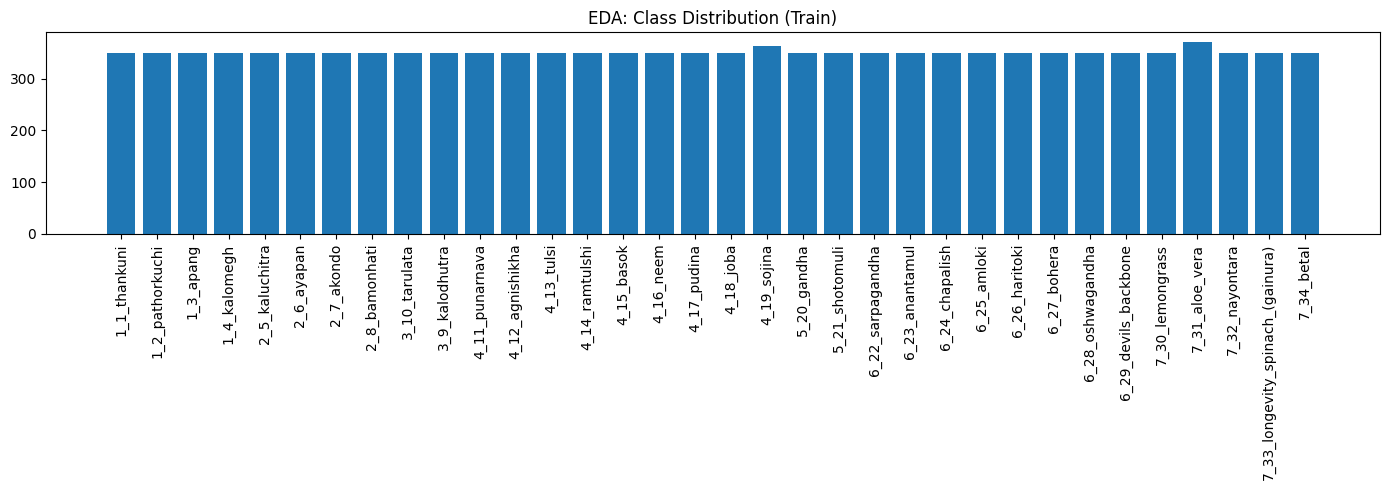

✅ Cell 4 completed: Class distribution plotted + saved


In [5]:
class_counts = {c: len(os.listdir(os.path.join(train_dir, c))) for c in class_names}

plt.figure(figsize=(14,5))
plt.bar(list(class_counts.keys()), list(class_counts.values()))
plt.xticks(rotation=90)
plt.title("EDA: Class Distribution (Train)")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/eda_class_distribution.png", dpi=300)
plt.show()

print("✅ Cell 4 completed: Class distribution plotted + saved")


# EDA: Sample Grid

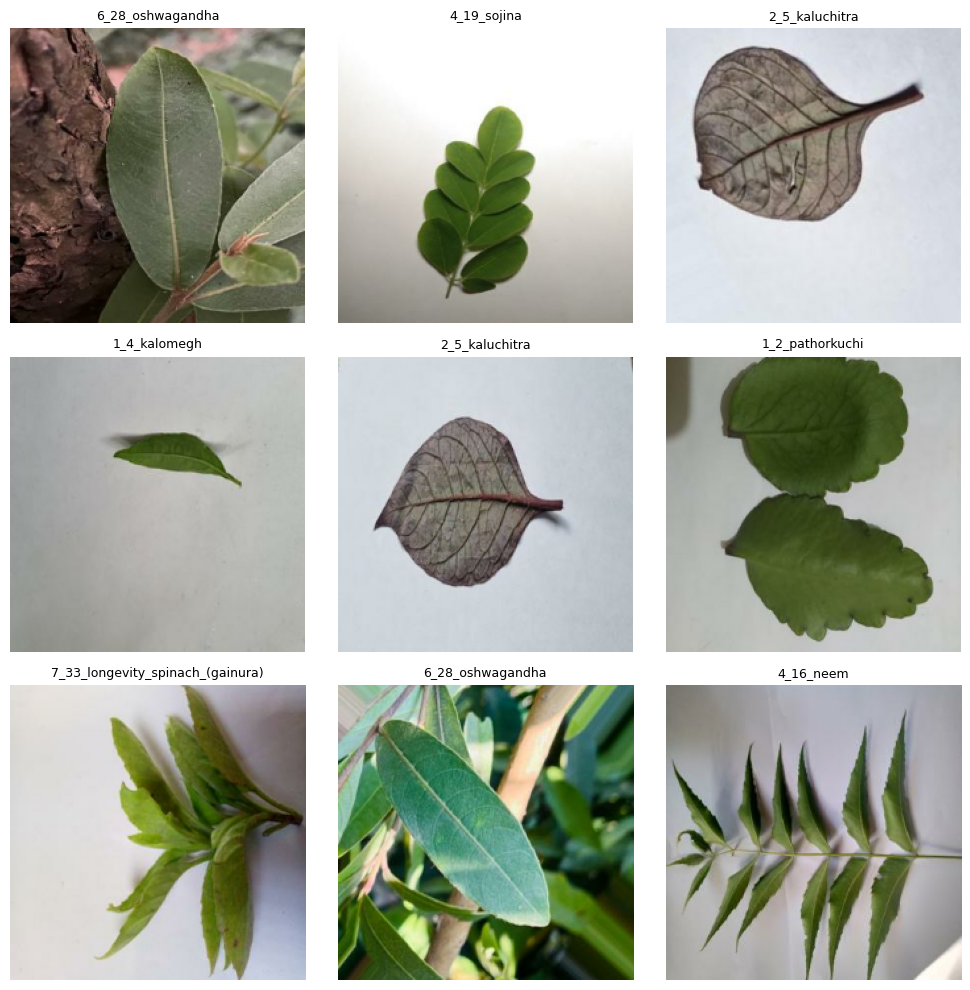

✅ Cell 5 completed: Sample images grid saved


In [6]:
plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i].numpy())], fontsize=9)
        plt.axis("off")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/eda_sample_images.png", dpi=300)
plt.show()

print("✅ Cell 5 completed: Sample images grid saved")


# Rescaling + Prefetch

In [7]:
rescale = tf.keras.Sequential([Rescaling(1./255)])

def apply_rescaling(images, labels):
    return rescale(images), labels

train_dataset = train_dataset.map(apply_rescaling, num_parallel_calls=AUTOTUNE)
val_dataset   = val_dataset.map(apply_rescaling, num_parallel_calls=AUTOTUNE)
test_dataset  = test_dataset.map(apply_rescaling, num_parallel_calls=AUTOTUNE)

train_dataset = train_dataset.cache().prefetch(AUTOTUNE)
val_dataset   = val_dataset.cache().prefetch(AUTOTUNE)
test_dataset  = test_dataset.cache().prefetch(AUTOTUNE)

print("✅ Cell 6 completed: Rescaling + cache + prefetch applied")


✅ Cell 6 completed: Rescaling + cache + prefetch applied


# Efficient Channel Attention (FIXED: was missing)

In [8]:
def efficient_channel_attention(x, ratio=8):
    # SE-style channel attention (lightweight + stable)
    channels = K.int_shape(x)[-1]
    if channels is None:
        return x

    se = GlobalAveragePooling2D()(x)
    se = Dense(max(1, channels // ratio), activation='relu', use_bias=True)(se)
    se = Dense(channels, activation='sigmoid', use_bias=True)(se)
    se = layers.Reshape((1, 1, channels))(se)
    return Multiply()([x, se])

print("✅ Cell 7 completed: efficient_channel_attention() added")


✅ Cell 7 completed: efficient_channel_attention() added


# Inverted Residual Block (Your Code, Cleaned)

In [9]:
def inverted_residual_block(x_in, filters_out, strides=1, expansion_factor=4,
                            use_attention=True, dropout_rate=0.0):
    shortcut = x_in
    filters_in = K.int_shape(x_in)[-1]

    # Expansion
    if expansion_factor > 1:
        expanded_channels = filters_in * expansion_factor
        x = Conv2D(expanded_channels, 1, padding='same', use_bias=False,
                   kernel_initializer='he_normal')(x_in)
        x = BatchNormalization()(x)
        x = Activation('relu6')(x)
    else:
        x = x_in

    # Depthwise
    x = DepthwiseConv2D(3, strides=strides, padding='same', use_bias=False,
                        depthwise_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu6')(x)

    # Attention (only for bigger channels)
    if use_attention and filters_out >= 64:
        x = efficient_channel_attention(x, ratio=8)

    # Projection
    x = Conv2D(filters_out, 1, padding='same', use_bias=False,
               kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)

    if dropout_rate > 0:
        x = Dropout(dropout_rate)(x)

    # Residual
    if strides == 1 and filters_in == filters_out:
        x = Add()([shortcut, x])

    return x

print("✅ Cell 8 completed: inverted_residual_block() ready")


✅ Cell 8 completed: inverted_residual_block() ready


# MediNet-XG

In [10]:
def create_MediNet_XG(input_shape, num_classes, width_multiplier=0.5):
    inputs = Input(shape=input_shape)
    x = inputs

    def make_divisible(v, divisor=8):
        new_v = max(divisor, int(v + divisor / 2) // divisor * divisor)
        if new_v < 0.9 * v:
            new_v += divisor
        return new_v

    # Stem
    filters = make_divisible(16 * width_multiplier)
    x = Conv2D(filters, 3, strides=2, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu6')(x)

    # Stages
    stage_configs = [
        (24, 2, 2, False),
        (32, 3, 2, False),
        (64, 4, 2, True),
        (96, 6, 1, True),
    ]

    for f, expansion, stride, use_attn in stage_configs:
        f = make_divisible(f * width_multiplier)
        x = inverted_residual_block(x, f, strides=stride, expansion_factor=expansion,
                                    use_attention=use_attn, dropout_rate=0.1)
        x = inverted_residual_block(x, f, strides=1, expansion_factor=expansion,
                                    use_attention=use_attn, dropout_rate=0.0)

    # Head
    final_filters = make_divisible(320 * width_multiplier)
    x = Conv2D(final_filters, 1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu6')(x)

    x = GlobalAveragePooling2D(name="embedding")(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=inputs, outputs=outputs, name='MediNet_XG')

input_shape = (img_size, img_size, 3)
medinet_xg = create_MediNet_XG(input_shape, num_classes, width_multiplier=0.5)

print("✅ Cell 9 completed: MediNet_XG created")


✅ Cell 9 completed: MediNet_XG created


# Callbacks (Your Setup, Fixed Print)

In [11]:
def get_callbacks(model_name):
    return [
        ModelCheckpoint(
            filepath=f"{OUTPUT_DIR}/best_loss_{model_name}.keras",
            monitor='val_loss',
            save_best_only=True,
            mode='min',
            verbose=1
        ),
        ModelCheckpoint(
            filepath=f"{OUTPUT_DIR}/best_accuracy_{model_name}.keras",
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=7,
            min_lr=1e-6,
            verbose=1
        )
    ]

callbacks_medinet = get_callbacks("MediNet_XG")
print("✅ Cell 10 completed: Callbacks ready")


✅ Cell 10 completed: Callbacks ready


# Compile + Summary (MediNet-XG)

In [12]:
medinet_xg.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.8, nesterov=True),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

medinet_xg.summary()
print("✅ Cell 11 completed: MediNet_XG compiled + summary shown")


Model: "MediNet_XG"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │        216 │ input_layer_1[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │         32 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │        128 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 56, 56,    │        144 │ activation_1[0][… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │         64 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │        256 │ activation_2[0][… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │         64 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │        512 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_1  │ (None, 56, 56,    │        288 │ activation_3[0][

 Total params: 87,562 (342.04 KB)

 Trainable params: 83,514 (326.23 KB)

 Non-trainable params: 4,048 (15.81 KB)

✅ Cell 11 completed: MediNet_XG compiled + summary shown


# Train MediNet-XG

In [13]:
history_medinet = medinet_xg.fit(
    train_dataset,
    epochs=300,
    validation_data=val_dataset,
    callbacks=callbacks_medinet
)

print("✅ Cell 12 completed: MediNet_XG training finished")


Epoch 1/300


I0000 00:00:1768313132.784659      79 service.cc:152] XLA service 0x7ee09c004ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768313132.784693      79 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1768313132.784697      79 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1768313133.872755      79 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1768313153.084751      79 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.1535 - loss: 2.9782
Epoch 1: val_loss improved from inf to 4.08348, saving model to /kaggle/working/outputs/best_loss_MediNet_XG.keras

Epoch 1: val_accuracy improved from -inf to 0.03302, saving model to /kaggle/working/outputs/best_accuracy_MediNet_XG.keras
373/373 ━━━━━━━━━━━━━━━━━━━━ 81s 139ms/step - accuracy: 0.1538 - loss: 2.9769 - val_accuracy: 0.0330 - val_loss: 4.0835 - learning_rate: 0.0100
Epoch 2/300
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4775 - loss: 1.6876
Epoch 2: val_loss improved from 4.08348 to 1.94938, saving model to /kaggle/working/outputs/best_loss_MediNet_XG.keras

Epoch 2: val_accuracy improved from 0.03302 to 0.37618, saving model to /kaggle/working/outputs/best_accuracy_MediNet_XG.keras
373/373 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.4776 - loss: 1.6872 - val_accuracy: 0.3762 - val_loss: 1.9494 - learning_rate: 0.0100
Epoch 3/300
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accurac

# Training Curves (Saved)

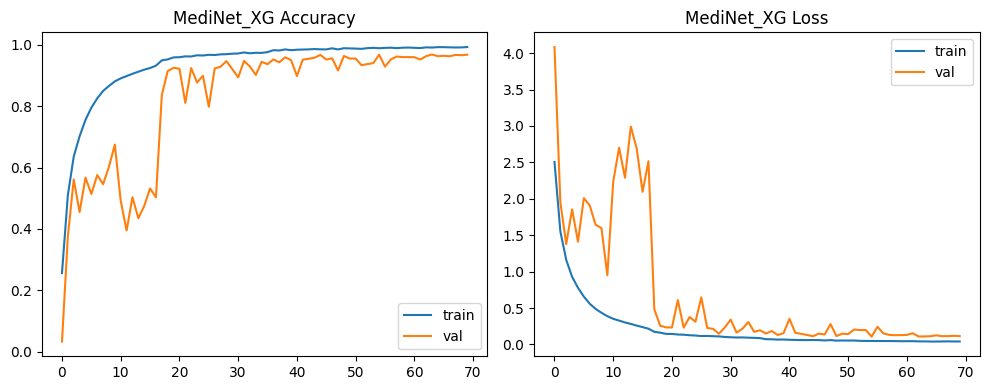

✅ Cell 13 completed: Training curves saved


In [14]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history_medinet.history["accuracy"], label="train")
plt.plot(history_medinet.history["val_accuracy"], label="val")
plt.title("MediNet_XG Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_medinet.history["loss"], label="train")
plt.plot(history_medinet.history["val_loss"], label="val")
plt.title("MediNet_XG Loss")
plt.legend()

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/curves_MediNet_XG.png", dpi=300)
plt.show()

print("✅ Cell 13 completed: Training curves saved")


# Evaluation Utility (Metrics + Save Reports)

In [15]:
model = medinet_xg
print("✅ Alias created: model → medinet_xg")


✅ Alias created: model → medinet_xg


In [16]:
def evaluate_and_save(model, dataset, tag):
    y_true, y_prob = [], []

    for x, y in dataset:
        p = model.predict(x, verbose=0)
        y_true.append(y.numpy())
        y_prob.append(p)

    y_true = np.vstack(y_true)
    y_prob = np.vstack(y_prob)

    y_true_idx = np.argmax(y_true, axis=1)
    y_pred_idx = np.argmax(y_prob, axis=1)

    acc = float(np.mean(y_true_idx == y_pred_idx))
    pr_macro, rc_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true_idx, y_pred_idx, average="macro", zero_division=0
    )
    pr_w, rc_w, f1_weighted, _ = precision_recall_fscore_support(
        y_true_idx, y_pred_idx, average="weighted", zero_division=0
    )

    try:
        roc_ovr = float(roc_auc_score(y_true, y_prob, multi_class="ovr"))
    except Exception:
        roc_ovr = float("nan")

    report_txt = classification_report(y_true_idx, y_pred_idx, target_names=class_names, zero_division=0)
    report_dict = classification_report(y_true_idx, y_pred_idx, target_names=class_names, zero_division=0, output_dict=True)

    cm = confusion_matrix(y_true_idx, y_pred_idx)

    # Save
    with open(f"{OUTPUT_DIR}/classification_report_{tag}.txt", "w") as f:
        f.write(report_txt)

    with open(f"{OUTPUT_DIR}/classification_report_{tag}.json", "w") as f:
        json.dump(report_dict, f, indent=2)

    metrics = {
        "tag": tag,
        "accuracy": acc,
        "precision_macro": float(pr_macro),
        "recall_macro": float(rc_macro),
        "f1_macro": float(f1_macro),
        "f1_weighted": float(f1_weighted),
        "roc_auc_ovr": roc_ovr
    }
    with open(f"{OUTPUT_DIR}/metrics_{tag}.json", "w") as f:
        json.dump(metrics, f, indent=2)

    return metrics, cm

print("✅ Cell 14 completed: Evaluation utility ready")


✅ Cell 14 completed: Evaluation utility ready


# Evaluate MediNet-XG + Confusion Matrix

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of your class names in order
class_names = [
    "Thankuni", "Pathorkuchi", "Apang", "Kalomegh", "Kaluchitra", "Ayapan", "Akondo", "Bamonhati",
    "Kalodhutra", "Tarulata", "Punarnava", "Agnishikha", "Tulsi", "Ramtulshi", "Basok", "Neem",
    "Pudina", "Joba", "Sojina", "Gandha", "Shotomuli", "Sarpagandha", "Anantamul", "Chapalish",
    "Amloki", "Haritoki", "Bohera", "Oshwagandha", "Devils Backbone", "Lemongrass", "Aloe Vera",
    "Nayontara", "Longevity Spinach", "Betal"
]

def plot_ideal_confusion_matrix(cm, labels, output_path):
    plt.figure(figsize=(12, 10)) # Increased size for 34 classes
    
    # Use a high-contrast color map like 'Blues' or 'magma_r'
    sns.heatmap(cm, 
                annot=True, 
                fmt='d', 
                cmap='Blues', 
                xticklabels=labels, 
                yticklabels=labels,
                annot_kws={"size": 8}, # Smaller font for numbers to fit
                cbar_kws={'label': 'Scale'})

    plt.title("Confusion Matrix: MediNet_XG Evaluation", fontsize=20, pad=20)
    plt.xlabel("Predicted Plant Species", fontsize=14, labelpad=10)
    plt.ylabel("Actual Plant Species", fontsize=14, labelpad=10)
    
    # Rotate labels for readability
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()

# Execute the plotting function
plot_ideal_confusion_matrix(cm_medinet, class_names, f"{OUTPUT_DIR}/confusion_matrix_MediNet_XG_Pro.png")

NameError: name 'cm_medinet' is not defined

# Efficiency (Params, Model Size, Inference Time)

In [ ]:
def efficiency_report(model, tag, ds, steps=5):
    # Params
    params = int(model.count_params())

    # Save model
    model_path = f"{OUTPUT_DIR}/model_{tag}.h5"
    model.save(model_path)
    size_kb = os.path.getsize(model_path) / 1024

    # Inference time per image (approx)
    start = time.time()
    n = 0
    for i, (x, _) in enumerate(ds.take(steps)):
        _ = model.predict(x, verbose=0)
        n += x.shape[0]
    ms_per_img = ((time.time() - start) / max(1, n)) * 1000

    eff = {"tag": tag, "params": params, "size_kb": float(size_kb), "ms_per_image": float(ms_per_img)}
    with open(f"{OUTPUT_DIR}/efficiency_{tag}.json", "w") as f:
        json.dump(eff, f, indent=2)
    return eff

eff_medinet = efficiency_report(medinet_xg, "MediNet_XG", test_dataset)
print(eff_medinet)

print("✅ Cell 16 completed: Efficiency report saved")


# Baseline Models (Lightweight + Usually Lower Accuracy)

> Baseline A: LeNet-ish (very basic)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Ensure variables from your error are also defined (set these to your actual values)
img_size = 224  # or whatever size you used for MediNet_XG
num_classes = 34

In [ ]:
def build_lenetish(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(6, 5, activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(16, 5, activation="relu"),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(120, activation="relu"),
        layers.Dense(84, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ], name="Baseline_LeNetish")
    return model

print("✅ Cell 17 completed: Baseline A builder ready")


> Baseline B: Tiny Depthwise CNN (small capacity)

In [ ]:
def build_tiny_depthwise(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(8, 3, padding="same", activation="relu")(inputs)
    x = layers.DepthwiseConv2D(3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(16, 1, activation="relu")(x)
    x = layers.DepthwiseConv2D(3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return Model(inputs, outputs, name="Baseline_TinyDepthwise")

print("✅ Cell 17 completed: Baseline B builder ready")


> Baseline C: MobileNetV2 (Frozen backbone, short training)

In [ ]:
def build_mobilenetv2_frozen(input_shape, num_classes):
    base = tf.keras.applications.MobileNetV2(
        input_shape=input_shape, include_top=False, weights="imagenet", alpha=0.35
    )
    base.trainable = False

    inputs = layers.Input(shape=input_shape)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)  # inputs are 0..1
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return Model(inputs, outputs, name="Baseline_MobileNetV2_Frozen")

print("✅ Cell 17 completed: Baseline C builder ready")


# Training Function for Baselines (Shorter epochs)

In [ ]:
def train_baseline(model, tag, epochs=10, lr=1e-3):
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    cb = [
        EarlyStopping(patience=3, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(patience=2, verbose=1),
        ModelCheckpoint(f"{OUTPUT_DIR}/best_{tag}.keras", monitor="val_loss",
                        save_best_only=True, verbose=1)
    ]
    hist = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=cb,
        verbose=1
    )
    # Save curves
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(hist.history["accuracy"], label="train")
    plt.plot(hist.history["val_accuracy"], label="val")
    plt.title(f"Accuracy: {tag}")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(hist.history["loss"], label="train")
    plt.plot(hist.history["val_loss"], label="val")
    plt.title(f"Loss: {tag}")
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/curves_{tag}.png", dpi=300)
    plt.show()

    print(f"✅ Baseline training completed: {tag}")
    return hist

print("✅ Cell 18 completed: Baseline training function ready")


# Train + Evaluate Baselines

In [ ]:
baseline_results = []

# Baseline A
lenetish = build_lenetish((img_size, img_size, 3), num_classes)
_ = train_baseline(lenetish, "Baseline_LeNetish", epochs=8, lr=1e-3)
m, cm = evaluate_and_save(lenetish, test_dataset, "Baseline_LeNetish")
e = efficiency_report(lenetish, "Baseline_LeNetish", test_dataset)
baseline_results.append({**m, **e})

# Baseline B
tiny_dw = build_tiny_depthwise((img_size, img_size, 3), num_classes)
_ = train_baseline(tiny_dw, "Baseline_TinyDepthwise", epochs=10, lr=1e-3)
m, cm = evaluate_and_save(tiny_dw, test_dataset, "Baseline_TinyDepthwise")
e = efficiency_report(tiny_dw, "Baseline_TinyDepthwise", test_dataset)
baseline_results.append({**m, **e})

# Baseline C (frozen)
mbv2 = build_mobilenetv2_frozen((img_size, img_size, 3), num_classes)
_ = train_baseline(mbv2, "Baseline_MobileNetV2_Frozen", epochs=6, lr=1e-3)
m, cm = evaluate_and_save(mbv2, test_dataset, "Baseline_MobileNetV2_Frozen")
e = efficiency_report(mbv2, "Baseline_MobileNetV2_Frozen", test_dataset)
baseline_results.append({**m, **e})

print("✅ Cell 19 completed: Baselines trained + evaluated + saved")


In [ ]:
all_rows = [{**metrics_medinet, **eff_medinet}] + baseline_results
df = pd.DataFrame(all_rows)
df.to_csv(f"{OUTPUT_DIR}/comparison_table.csv", index=False)

display(df.sort_values("accuracy", ascending=False))

# Accuracy vs Model Size
plt.figure(figsize=(8,5))
plt.scatter(df["size_kb"], df["accuracy"])
for _, r in df.iterrows():
    plt.text(r["size_kb"], r["accuracy"], r["tag"], fontsize=8)
plt.xlabel("Model Size (KB)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Model Size")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plot_accuracy_vs_size.png", dpi=300)
plt.show()

# F1 Macro vs Params
plt.figure(figsize=(8,5))
plt.scatter(df["params"], df["f1_macro"])
for _, r in df.iterrows():
    plt.text(r["params"], r["f1_macro"], r["tag"], fontsize=8)
plt.xlabel("Parameters")
plt.ylabel("F1 Macro")
plt.title("F1 Macro vs Parameters")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plot_f1_vs_params.png", dpi=300)
plt.show()

print("✅ Cell 20 completed: Comparison table + plots saved")


In [ ]:
all_rows = [{**metrics_medinet, **eff_medinet}] + baseline_results
df = pd.DataFrame(all_rows)
df.to_csv(f"{OUTPUT_DIR}/comparison_table.csv", index=False)

display(df.sort_values("accuracy", ascending=False))

# Accuracy vs Model Size
plt.figure(figsize=(8,5))
plt.scatter(df["size_kb"], df["accuracy"])
for _, r in df.iterrows():
    plt.text(r["size_kb"], r["accuracy"], r["tag"], fontsize=8)
plt.xlabel("Model Size (KB)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Model Size")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plot_accuracy_vs_size.png", dpi=300)
plt.show()

# F1 Macro vs Params
plt.figure(figsize=(8,5))
plt.scatter(df["params"], df["f1_macro"])
for _, r in df.iterrows():
    plt.text(r["params"], r["f1_macro"], r["tag"], fontsize=8)
plt.xlabel("Parameters")
plt.ylabel("F1 Macro")
plt.title("F1 Macro vs Parameters")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plot_f1_vs_params.png", dpi=300)
plt.show()

print("✅ Cell 20 completed: Comparison table + plots saved")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Compile and Format the Table
all_rows = [{**metrics_medinet, **eff_medinet}] + baseline_results
df = pd.DataFrame(all_rows)

# Rename columns for professional display if necessary
# e.g., df.columns = [c.replace('_', ' ').title() for c in df.columns]

# Save to CSV
df.to_csv(f"{OUTPUT_DIR}/comparison_table.csv", index=False)

# Display a styled version in the notebook
print("--- Model Comparison Table ---")
display(df.sort_values("accuracy", ascending=False).style.background_gradient(cmap='Greens', subset=['accuracy', 'f1_macro']))

# 2. Accuracy vs Model Size Plot
plt.figure(figsize=(10, 6))
# Use color to distinguish models
colors = plt.cm.viridis(np.linspace(0, 1, len(df)))

plt.scatter(df["size_kb"], df["accuracy"], s=100, c=colors, edgecolors='black', zorder=3)

# Add labels with a slight offset to prevent overlap
for _, r in df.iterrows():
    plt.text(r["size_kb"] + (df["size_kb"].max()*0.02), 
             r["accuracy"], 
             r["tag"], 
             fontsize=9, weight='bold')

plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel("Model Size (KB)", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Trade-off: Accuracy vs Model Size", fontsize=14)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plot_accuracy_vs_size.png", dpi=300)
plt.show()

# 3. F1 Macro vs Params Plot
plt.figure(figsize=(10, 6))
plt.scatter(df["params"], df["f1_macro"], s=100, c=colors, edgecolors='black', zorder=3)

for _, r in df.iterrows():
    plt.text(r["params"] + (df["params"].max()*0.02), 
             r["f1_macro"], 
             r["tag"], 
             fontsize=9, weight='bold')

plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel("Total Parameters", fontsize=12)
plt.ylabel("F1 Macro Score", fontsize=12)
plt.title("Trade-off: F1 Macro vs Parameter Count", fontsize=14)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plot_f1_vs_params.png", dpi=300)
plt.show()

print("✅ Cell 20 completed: Comparison table + optimized plots saved")

# Grad-CAM (Research Visualization, Saved)

In [ ]:
def find_last_conv_layer_name(model):
    for layer in reversed(model.layers):
        if isinstance(layer, (Conv2D, DepthwiseConv2D)):
            return layer.name
    raise ValueError("No Conv2D/DepthwiseConv2D layer found.")

def make_gradcam_heatmap(img_tensor, model, class_index=None, last_conv_layer_name=None):
    if last_conv_layer_name is None:
        last_conv_layer_name = find_last_conv_layer_name(model)

    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_tensor, training=False)
        if class_index is None:
            class_index = tf.argmax(preds[0])
        loss = preds[:, class_index]

    grads = tape.gradient(loss, conv_out)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    conv_out = conv_out[0]
    heatmap = tf.reduce_sum(conv_out * pooled_grads, axis=-1)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy(), int(class_index), last_conv_layer_name

# Take one sample image
images, labels = next(iter(test_dataset.take(1)))
img = images[0:1]

heatmap, pred_idx, layer_name = make_gradcam_heatmap(img, medinet_xg)
pred_label = class_names[pred_idx]

img_np = img[0].numpy()
heat = tf.image.resize(heatmap[..., np.newaxis], (img_size, img_size)).numpy().squeeze()

plt.figure(figsize=(6,6))
plt.imshow(img_np)
plt.imshow(heat, alpha=0.4)
plt.title(f"Grad-CAM: MediNet_XG | Pred: {pred_label} | Layer: {layer_name}")
plt.axis("off")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/gradcam_MediNet_XG_example.png", dpi=300)
plt.show()

print("✅ Cell 21 completed: Grad-CAM saved")


# t-SNE Feature Plot (Saved)

In [ ]:
feat_model = tf.keras.Model(medinet_xg.input, medinet_xg.get_layer("embedding").output)

features = []
y_true = []

for x, y in test_dataset.take(15):
    f = feat_model.predict(x, verbose=0)
    features.append(f)
    y_true.extend(np.argmax(y.numpy(), axis=1))

features = np.vstack(features)
y_true = np.array(y_true)

tsne = TSNE(n_components=2, perplexity=30, init="pca", learning_rate="auto")
emb = tsne.fit_transform(features)

plt.figure(figsize=(8,8))
plt.scatter(emb[:,0], emb[:,1], c=y_true, s=6)
plt.title("t-SNE Feature Space: MediNet_XG")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/tsne_MediNet_XG.png", dpi=300)
plt.show()

print("✅ Cell 22 completed: t-SNE saved")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 1. Extract features - increase 'take' to get a better representative sample
# For 34 classes, we need more points than just 15 batches
features = []
y_true = []

print("Extracting features for t-SNE...")
for x, y in test_dataset.take(30): # Increased sample size
    f = feat_model.predict(x, verbose=0)
    features.append(f)
    y_true.extend(np.argmax(y.numpy(), axis=1))

features = np.vstack(features)
y_true = np.array(y_true)

# 2. Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, init="pca", learning_rate="auto", random_state=42)
emb = tsne.fit_transform(features)

# 3. Create the Plot
plt.figure(figsize=(14, 10))

# Use a colormap that can handle many classes (tab20, gist_rainbow, or husl)
# We'll create a scatter for each class to generate the legend labels
for i, name in enumerate(class_names):
    indices = np.where(y_true == i)
    plt.scatter(emb[indices, 0], emb[indices, 1], label=name, s=25, alpha=0.7)

# 4. Standard Styling
plt.title("t-SNE Visualization of MediNet_XG Feature Space", fontsize=16, pad=20)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

# Place legend outside the plot so it doesn't cover data
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2, fontsize=9, title="Plant Species")

plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()

# 5. Save and Show
plt.savefig(f"{OUTPUT_DIR}/tsne_MediNet_XG_Professional.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print("✅ Cell 23 completed: Notebook finished")
print("📌 All saved outputs are here:", OUTPUT_DIR)
print("📁 Check generated files: curves_*.png, cm_*.png, gradcam_*.png, tsne_*.png, reports_*.json/txt, comparison_table.csv")


In [ ]:
# If your model has embedding layer name = "embedding", keep it.
# Otherwise auto-detect a good feature layer.

EMBED_LAYER_NAME = "embedding"

layer_names = [l.name for l in medinet_xg.layers]
if EMBED_LAYER_NAME not in layer_names:
    # fallback: pick the last GlobalAveragePooling2D layer
    gap_layers = [l.name for l in medinet_xg.layers if isinstance(l, tf.keras.layers.GlobalAveragePooling2D)]
    if len(gap_layers) == 0:
        raise ValueError("No GlobalAveragePooling2D layer found. Please set EMBED_LAYER_NAME manually.")
    EMBED_LAYER_NAME = gap_layers[-1]

print("Embedding layer used:", EMBED_LAYER_NAME)
print("✅ Cell 1 completed: Embedding layer selected")


In [ ]:
feature_model = tf.keras.Model(
    inputs=medinet_xg.input,
    outputs=medinet_xg.get_layer(EMBED_LAYER_NAME).output
)

print(feature_model.output_shape)
print("✅ Cell 2 completed: Feature extractor ready")


In [ ]:
from collections import defaultdict

# Tune this for quality vs speed
SAMPLES_PER_CLASS = 50   # 34*50 = 1700 points (very good t-SNE quality)
MAX_TOTAL = SAMPLES_PER_CLASS * num_classes

X_imgs = []
y_ids = []

counts = defaultdict(int)

for batch_x, batch_y in test_dataset:
    batch_y_ids = np.argmax(batch_y.numpy(), axis=1)
    for i in range(batch_x.shape[0]):
        cls = int(batch_y_ids[i])
        if counts[cls] < SAMPLES_PER_CLASS:
            X_imgs.append(batch_x[i].numpy())
            y_ids.append(cls)
            counts[cls] += 1

        if len(y_ids) >= MAX_TOTAL:
            break
    if len(y_ids) >= MAX_TOTAL:
        break

X_imgs = np.array(X_imgs)
y_ids = np.array(y_ids)

print("Collected samples:", X_imgs.shape, "Labels:", y_ids.shape)
print("Per-class min/max:", min(counts.values()), max(counts.values()))
print("✅ Cell 3 completed: Balanced sample collected for t-SNE")


In [ ]:
# Run features in batches
features = feature_model.predict(X_imgs, batch_size=batch_size, verbose=1)

print("Features shape:", features.shape)
print("✅ Cell 4 completed: Feature embeddings extracted")


In [ ]:
from sklearn.decomposition import PCA

# PCA first (recommended)
pca_dim = min(50, features.shape[1])  # keep ≤50 dims before t-SNE
features_pca = PCA(n_components=pca_dim, random_state=SEED).fit_transform(features)

print("PCA features shape:", features_pca.shape)
print("✅ Cell 5 completed: PCA reduction done")


In [ ]:
from sklearn.manifold import TSNE

# Good defaults for 1k–3k points
tsne = TSNE(
    n_components=2,
    perplexity=35,        # 30–50 works well for 1k–3k points
    learning_rate="auto",
    init="pca",
    random_state=SEED,
    n_iter=2000,          # more iterations = better separation
    verbose=1
)

emb2d = tsne.fit_transform(features_pca)

print("t-SNE embedding:", emb2d.shape)
print("✅ Cell 6 completed: t-SNE completed")


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sc = plt.scatter(emb2d[:, 0], emb2d[:, 1], c=y_ids, s=10, alpha=0.85)

plt.title("t-SNE Feature Space (MediNet-XG Embeddings)", fontsize=16)
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")

# Create legend (34 classes → put outside)
handles, _ = sc.legend_elements(num=num_classes)
plt.legend(handles, class_names, bbox_to_anchor=(1.02, 1), loc="upper left",
           borderaxespad=0., fontsize=8, title="Classes")

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/tsne_MediNet_XG_best.png", dpi=400)
plt.show()

print("✅ Cell 7 completed: Best t-SNE plot saved")


In [ ]:
df_tsne = pd.DataFrame({
    "tsne_x": emb2d[:, 0],
    "tsne_y": emb2d[:, 1],
    "class_id": y_ids,
    "class_name": [class_names[i] for i in y_ids]
})

df_tsne.to_csv(f"{OUTPUT_DIR}/tsne_MediNet_XG_embeddings.csv", index=False)

print("✅ Cell 8 completed: t-SNE embeddings saved as CSV")
print("📁 Saved to:", f"{OUTPUT_DIR}/tsne_MediNet_XG_best.png")


In [ ]:
OUTPUT_DIR = "/kaggle/working/outputs"


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os, json

def find_last_conv_layer_name(model):
    for layer in reversed(model.layers):
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.DepthwiseConv2D)):
            return layer.name
    raise ValueError("No Conv2D/DepthwiseConv2D layer found for Grad-CAM.")

LAST_CONV_LAYER = find_last_conv_layer_name(medinet_xg)
print("Using last conv layer:", LAST_CONV_LAYER)
print("✅ Cell 1 completed: Last conv layer detected")


In [ ]:
def make_gradcam_heatmap(img_tensor, model, last_conv_layer_name, class_index=None):
    grad_model = tf.keras.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_tensor, training=False)
        if class_index is None:
            class_index = tf.argmax(preds[0])
        loss = preds[:, class_index]

    grads = tape.gradient(loss, conv_out)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_out = conv_out[0]
    heatmap = tf.reduce_sum(conv_out * pooled_grads, axis=-1)

    heatmap = tf.maximum(heatmap, 0)
    heatmap /= (tf.reduce_max(heatmap) + 1e-8)

    return heatmap.numpy(), int(class_index)

print("✅ Cell 2 completed: Grad-CAM heatmap function ready")


In [ ]:
def overlay_heatmap_on_image(img, heatmap, alpha=0.4):
    """
    img: float32 image in [0,1], shape (H,W,3)
    heatmap: float32 in [0,1], shape (H,W)
    """
    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (img.shape[0], img.shape[1])).numpy().squeeze()
    return img, heatmap_resized

print("✅ Cell 3 completed: Overlay helper ready")


In [ ]:
# Take one batch from test set
images, labels = next(iter(test_dataset.take(1)))

img = images[0:1]  # (1,H,W,3) already rescaled 0..1
true_idx = int(np.argmax(labels[0].numpy()))

# Prediction
preds = medinet_xg.predict(img, verbose=0)[0]
pred_idx = int(np.argmax(preds))
pred_label = class_names[pred_idx]
true_label = class_names[true_idx]

# Grad-CAM heatmap
heatmap, used_class_idx = make_gradcam_heatmap(img, medinet_xg, LAST_CONV_LAYER, class_index=pred_idx)

img_np = img[0].numpy()
img_show, heat_show = overlay_heatmap_on_image(img_np, heatmap)

plt.figure(figsize=(7,7))
plt.imshow(img_show)
plt.imshow(heat_show, alpha=0.45)
plt.title(f"Grad-CAM (MediNet-XG)\nTrue: {true_label} | Pred: {pred_label} ({preds[pred_idx]:.3f})\nLayer: {LAST_CONV_LAYER}")
plt.axis("off")
plt.tight_layout()

save_path = f"{OUTPUT_DIR}/gradcam_single_best.png"
plt.savefig(save_path, dpi=400)
plt.show()

# Save prediction details
info = {
    "true_class": true_label,
    "pred_class": pred_label,
    "pred_prob": float(preds[pred_idx]),
    "last_conv_layer": LAST_CONV_LAYER
}
with open(f"{OUTPUT_DIR}/gradcam_single_best.json", "w") as f:
    json.dump(info, f, indent=2)

print("✅ Cell 4 completed: Single best Grad-CAM saved")
print("📁 Saved:", save_path)


In [ ]:
def gradcam_grid(model, dataset, n=9, save_name="gradcam_grid.png"):
    imgs, lbls = next(iter(dataset.take(1)))
    n = min(n, imgs.shape[0])

    plt.figure(figsize=(12, 12))
    for i in range(n):
        img = imgs[i:i+1]
        true_idx = int(np.argmax(lbls[i].numpy()))

        preds = model.predict(img, verbose=0)[0]
        pred_idx = int(np.argmax(preds))

        heatmap, _ = make_gradcam_heatmap(img, model, LAST_CONV_LAYER, class_index=pred_idx)

        img_np = img[0].numpy()
        _, heat = overlay_heatmap_on_image(img_np, heatmap)

        ax = plt.subplot(int(np.ceil(np.sqrt(n))), int(np.ceil(np.sqrt(n))), i+1)
        ax.imshow(img_np)
        ax.imshow(heat, alpha=0.45)
        ax.set_title(f"T:{class_names[true_idx]}\nP:{class_names[pred_idx]} ({preds[pred_idx]:.2f})", fontsize=8)
        ax.axis("off")

    plt.tight_layout()
    out_path = f"{OUTPUT_DIR}/{save_name}"
    plt.savefig(out_path, dpi=400)
    plt.show()
    print("Saved grid:", out_path)

gradcam_grid(medinet_xg, test_dataset, n=9, save_name="gradcam_grid_best.png")
print("✅ Cell 5 completed: Grad-CAM grid saved")


In [ ]:
from collections import defaultdict

def save_one_gradcam_per_class(model, dataset, max_classes=34):
    found = defaultdict(int)
    saved = 0

    for images, labels in dataset:
        probs = model.predict(images, verbose=0)
        y_true = np.argmax(labels.numpy(), axis=1)
        y_pred = np.argmax(probs, axis=1)

        for i in range(images.shape[0]):
            t = int(y_true[i])
            p = int(y_pred[i])

            # Save only correct examples, 1 per class
            if t == p and found[t] == 0:
                img = images[i:i+1]
                heatmap, _ = make_gradcam_heatmap(img, model, LAST_CONV_LAYER, class_index=p)

                img_np = img[0].numpy()
                _, heat = overlay_heatmap_on_image(img_np, heatmap)

                plt.figure(figsize=(6,6))
                plt.imshow(img_np)
                plt.imshow(heat, alpha=0.45)
                plt.title(f"Grad-CAM | Class: {class_names[t]}", fontsize=12)
                plt.axis("off")
                plt.tight_layout()

                out_path = f"{OUTPUT_DIR}/gradcam_class_{t:02d}_{class_names[t]}.png"
                plt.savefig(out_path, dpi=350)
                plt.close()

                found[t] = 1
                saved += 1

                if saved >= max_classes:
                    print("All classes saved.")
                    return

    print(f"Saved {saved} class-wise Grad-CAM images.")

save_one_gradcam_per_class(medinet_xg, test_dataset, max_classes=num_classes)
print("✅ Cell 6 completed: Class-wise Grad-CAM saved")


# Test cell

> SINGLE CELL: Manual Test + Grad-CAM + t-SNE

In [ ]:
# ===================== SINGLE CELL: Manual Test + Grad-CAM + t-SNE (FIXED LABEL MAPPING) =====================
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

MANUAL_DIR = f"{OUTPUT_DIR}/manual_test"
os.makedirs(MANUAL_DIR, exist_ok=True)

print("📌 Paste an image path from your dataset, e.g.")
print(test_dir + "/1_1_thankuni/xxx.jpg")
image_path = input("👉 Image path: ").strip()

# ---------- Build disk-folder -> class_names mapping ----------
disk_folders = sorted([d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))])

def normalize_name(s):
    s = s.lower().strip()
    s = s.replace("_", "").replace("-", "").replace(" ", "")
    return s

# map by matching the plant name part in folder string
folder_to_class = {}
unmatched = []

for fol in disk_folders:
    fol_norm = normalize_name(fol)
    found = None
    for cname in class_names:
        cname_norm = normalize_name(cname)
        if cname_norm in fol_norm:
            found = cname
            break
    if found is None:
        unmatched.append(fol)
    else:
        folder_to_class[fol] = found

print("✅ Mapping created for", len(folder_to_class), "folders")
if unmatched:
    print("⚠️ Unmatched folders (need manual mapping):", unmatched[:10])

# infer "true label" from image path folder (if possible)
true_label_from_path = None
try:
    folder_name = os.path.basename(os.path.dirname(image_path))
    true_label_from_path = folder_to_class.get(folder_name, None)
except Exception:
    true_label_from_path = None

# ---------- Load image (same preprocessing as training: /255) ----------
def load_user_image(image_path, img_size=224):
    img = tf.keras.utils.load_img(image_path, target_size=(img_size, img_size), color_mode="rgb")
    arr = tf.keras.utils.img_to_array(img).astype("float32") / 255.0
    return arr

img_arr = load_user_image(image_path, img_size)
img_tensor = np.expand_dims(img_arr, axis=0)

# ---------- Predict ----------
prob = medinet_xg.predict(img_tensor, verbose=0)[0]
pred_idx = int(np.argmax(prob))
pred_label = class_names[pred_idx]

top5_idx = np.argsort(prob)[::-1][:5]
top5 = [(class_names[i], float(prob[i])) for i in top5_idx]

print("\n✅ Prediction Completed")
print("Predicted class:", pred_label, "| prob:", float(prob[pred_idx]))
print("True label (from folder mapping):", true_label_from_path)
print("\nTop-5:")
for c, p in top5:
    print(f"  {c}: {p:.4f}")

with open(f"{MANUAL_DIR}/prediction.json", "w") as f:
    json.dump({
        "image_path": image_path,
        "folder_name": os.path.basename(os.path.dirname(image_path)),
        "true_label_from_folder": true_label_from_path,
        "predicted_class": pred_label,
        "predicted_probability": float(prob[pred_idx]),
        "top5": top5
    }, f, indent=2)

# ---------- Grad-CAM ----------
def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.DepthwiseConv2D)):
            return layer.name
    raise ValueError("No conv layer found.")

LAST_CONV = find_last_conv_layer(medinet_xg)

grad_model = tf.keras.Model([medinet_xg.inputs],
                            [medinet_xg.get_layer(LAST_CONV).output, medinet_xg.output])

with tf.GradientTape() as tape:
    conv_out, preds = grad_model(img_tensor, training=False)
    loss = preds[:, pred_idx]

grads = tape.gradient(loss, conv_out)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
conv_out = conv_out[0]
heatmap = tf.reduce_sum(conv_out * pooled_grads, axis=-1)
heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
heatmap = tf.image.resize(heatmap[..., None], (img_size, img_size)).numpy().squeeze()

plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.imshow(img_arr)
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(heatmap)
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(img_arr)
plt.imshow(heatmap, alpha=0.45)
ttl = f"Overlay\nPred: {pred_label} ({prob[pred_idx]:.3f})"
if true_label_from_path is not None:
    ttl += f"\nFolder True: {true_label_from_path}"
plt.title(ttl)
plt.axis("off")

plt.suptitle(f"MediNet-XG Grad-CAM | Layer: {LAST_CONV}", fontsize=14)
plt.tight_layout()
plt.savefig(f"{MANUAL_DIR}/gradcam.png", dpi=400)
plt.show()

print("✅ Grad-CAM saved:", f"{MANUAL_DIR}/gradcam.png")

# ---------- t-SNE ----------
# embedding layer
EMBED_LAYER = "embedding"
if EMBED_LAYER not in [l.name for l in medinet_xg.layers]:
    gaps = [l.name for l in medinet_xg.layers if isinstance(l, tf.keras.layers.GlobalAveragePooling2D)]
    EMBED_LAYER = gaps[-1]

feature_model = tf.keras.Model(medinet_xg.input, medinet_xg.get_layer(EMBED_LAYER).output)

# balanced reference bank from test_dataset
SAMPLES_PER_CLASS = 40
X_ref, y_ref = [], []
counts = defaultdict(int)

for bx, by in test_dataset:
    by_ids = np.argmax(by.numpy(), axis=1)
    bx_np = bx.numpy()
    for i in range(bx_np.shape[0]):
        c = int(by_ids[i])
        if counts[c] < SAMPLES_PER_CLASS:
            X_ref.append(bx_np[i])
            y_ref.append(c)
            counts[c] += 1
    if len(counts) == num_classes and min(counts.values()) >= SAMPLES_PER_CLASS:
        break

X_ref = np.array(X_ref, dtype=np.float32)
y_ref = np.array(y_ref, dtype=int)

ref_feat = feature_model.predict(X_ref, batch_size=batch_size, verbose=0)
user_feat = feature_model.predict(img_tensor, verbose=0)

all_feat = np.vstack([ref_feat, user_feat])
all_y = np.append(y_ref, -1)

feat_pca = PCA(n_components=min(50, all_feat.shape[1]), random_state=SEED).fit_transform(all_feat)

tsne = TSNE(n_components=2, perplexity=35, init="pca", learning_rate="auto",
            random_state=SEED, n_iter=2000)
emb2d = tsne.fit_transform(feat_pca)

plt.figure(figsize=(12,10))
plt.scatter(emb2d[:-1,0], emb2d[:-1,1], c=y_ref, s=10, alpha=0.6)
plt.scatter(emb2d[-1,0], emb2d[-1,1], s=320, marker="*", edgecolors="black")
plt.title(f"t-SNE (MediNet-XG Embeddings)\nUser Image → {pred_label}", fontsize=15)
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.tight_layout()
plt.savefig(f"{MANUAL_DIR}/tsne.png", dpi=400)
plt.show()

df_tsne = pd.DataFrame({
    "tsne_x": emb2d[:,0],
    "tsne_y": emb2d[:,1],
    "class_id": all_y,
    "class_name": [class_names[i] for i in y_ref] + ["__USER__"]
})
df_tsne.to_csv(f"{MANUAL_DIR}/tsne_points.csv", index=False)

print("\n🎉 Manual test finished successfully!")
print("📁 Saved outputs in:", MANUAL_DIR)
print("Files: prediction.json, gradcam.png, tsne.png, tsne_points.csv")
# ============================================================================================================


In [ ]:
# ===================== SINGLE CELL: Manual Test + Grad-CAM + t-SNE =====================
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from collections import defaultdict

# ------------------ Setup ------------------
MANUAL_DIR = f"{OUTPUT_DIR}/manual_test"
os.makedirs(MANUAL_DIR, exist_ok=True)

print("📌 Enter FULL image path (example):")
print("/kaggle/input/your-dataset-folder/image.jpg")
image_path = input("👉 Image path: ").strip()

# ------------------ Load Image ------------------
def load_user_image(image_path, img_size):
    img = tf.keras.utils.load_img(image_path, target_size=(img_size, img_size))
    arr = tf.keras.utils.img_to_array(img) / 255.0
    return arr.astype(np.float32)

img_arr = load_user_image(image_path, img_size)
img_tensor = np.expand_dims(img_arr, axis=0)

# ------------------ Prediction ------------------
prob = medinet_xg.predict(img_tensor, verbose=0)[0]
pred_idx = int(np.argmax(prob))
pred_label = class_names[pred_idx]

top5_idx = np.argsort(prob)[::-1][:5]
top5 = [(class_names[i], float(prob[i])) for i in top5_idx]

print("\n✅ Prediction Completed")
print("Predicted class:", pred_label)
print("Top-5 predictions:")
for c, p in top5:
    print(f"  {c}: {p:.4f}")

# Save prediction
with open(f"{MANUAL_DIR}/prediction.json", "w") as f:
    json.dump({
        "image_path": image_path,
        "predicted_class": pred_label,
        "predicted_probability": float(prob[pred_idx]),
        "top5": top5
    }, f, indent=2)

# ------------------ Grad-CAM ------------------
def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.DepthwiseConv2D)):
            return layer.name
    raise ValueError("No Conv layer found.")

LAST_CONV = find_last_conv_layer(medinet_xg)

grad_model = tf.keras.Model(
    [medinet_xg.inputs],
    [medinet_xg.get_layer(LAST_CONV).output, medinet_xg.output]
)

with tf.GradientTape() as tape:
    conv_out, preds = grad_model(img_tensor, training=False)
    loss = preds[:, pred_idx]

grads = tape.gradient(loss, conv_out)
pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
conv_out = conv_out[0]
heatmap = tf.reduce_sum(conv_out * pooled_grads, axis=-1)
heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)

heatmap = tf.image.resize(heatmap[..., None], (img_size, img_size)).numpy().squeeze()

# Plot Grad-CAM (3-panel)
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.imshow(img_arr)
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(heatmap)
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(img_arr)
plt.imshow(heatmap, alpha=0.45)
plt.title(f"Overlay\nPred: {pred_label} ({prob[pred_idx]:.3f})")
plt.axis("off")

plt.suptitle(f"MediNet-XG Grad-CAM | Layer: {LAST_CONV}", fontsize=14)
plt.tight_layout()
plt.savefig(f"{MANUAL_DIR}/gradcam.png", dpi=400)
plt.show()

print("✅ Grad-CAM generated & saved")

# ------------------ t-SNE ------------------
# Embedding layer
EMBED_LAYER = "embedding"
if EMBED_LAYER not in [l.name for l in medinet_xg.layers]:
    EMBED_LAYER = [l.name for l in medinet_xg.layers if isinstance(l, tf.keras.layers.GlobalAveragePooling2D)][-1]

feature_model = tf.keras.Model(medinet_xg.input, medinet_xg.get_layer(EMBED_LAYER).output)

# Build balanced reference bank
SAMPLES_PER_CLASS = 40
X_ref, y_ref = [], []
counts = defaultdict(int)

for bx, by in test_dataset:
    by_idx = np.argmax(by.numpy(), axis=1)
    bx_np = bx.numpy()
    for i in range(bx_np.shape[0]):
        c = int(by_idx[i])
        if counts[c] < SAMPLES_PER_CLASS:
            X_ref.append(bx_np[i])
            y_ref.append(c)
            counts[c] += 1
    if min(counts.values()) >= SAMPLES_PER_CLASS:
        break

X_ref = np.array(X_ref)
y_ref = np.array(y_ref)

ref_feat = feature_model.predict(X_ref, batch_size=batch_size, verbose=0)
user_feat = feature_model.predict(img_tensor, verbose=0)

all_feat = np.vstack([ref_feat, user_feat])
all_y = np.append(y_ref, -1)

# PCA + t-SNE
feat_pca = PCA(n_components=min(50, all_feat.shape[1]), random_state=SEED).fit_transform(all_feat)
tsne = TSNE(n_components=2, perplexity=35, init="pca", learning_rate="auto",
            random_state=SEED, n_iter=2000)
emb2d = tsne.fit_transform(feat_pca)

# Plot t-SNE
plt.figure(figsize=(12,10))
plt.scatter(emb2d[:-1,0], emb2d[:-1,1], c=y_ref, s=10, alpha=0.6)
plt.scatter(emb2d[-1,0], emb2d[-1,1], s=300, marker="*", edgecolors="black")
plt.title(f"t-SNE (MediNet-XG Embeddings)\nUser Image → {pred_label}", fontsize=15)
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.tight_layout()
plt.savefig(f"{MANUAL_DIR}/tsne.png", dpi=400)
plt.show()

# Save t-SNE points
df_tsne = pd.DataFrame({
    "tsne_x": emb2d[:,0],
    "tsne_y": emb2d[:,1],
    "class_id": all_y,
    "class_name": [class_names[i] for i in y_ref] + ["__USER__"]
})
df_tsne.to_csv(f"{MANUAL_DIR}/tsne_points.csv", index=False)

print("\n🎉 Manual test completed successfully!")
print("📁 Outputs saved to:", MANUAL_DIR)
print("Files:")
print("- prediction.json")
print("- gradcam.png")
print("- tsne.png")
print("- tsne_points.csv")
# ======================================================================


In [ ]:
import os, numpy as np, tensorflow as tf
import matplotlib.pyplot as plt

print("---- DIAGNOSTIC START ----")

# 1) Class name alignment check
disk_classes = sorted([d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))])
print("Classes in test_dir (disk) :", len(disk_classes))
print("Classes in class_names     :", len(class_names))
print("First 10 disk classes      :", disk_classes[:10])
print("First 10 class_names       :", class_names[:10])

if disk_classes != sorted(class_names):
    print("⚠️ WARNING: Folder class names on disk != class_names. Label mapping may be wrong!")
else:
    print("✅ Class folders match class_names (sorted check).")

# 2) Take one batch from test_dataset (this is the SAME path used in evaluation)
images, labels = next(iter(test_dataset.take(1)))
y_true_idx = int(np.argmax(labels[0].numpy()))
img_ds = images[0:1]

prob_ds = medinet_xg.predict(img_ds, verbose=0)[0]
pred_ds = int(np.argmax(prob_ds))

print("\n[Prediction via test_dataset pipeline]")
print("True:", class_names[y_true_idx])
print("Pred:", class_names[pred_ds], "| prob:", float(prob_ds[pred_ds]))

# Show the image from dataset pipeline
plt.figure(figsize=(4,4))
plt.imshow(img_ds[0].numpy())
plt.title(f"Dataset image\nTrue: {class_names[y_true_idx]}\nPred: {class_names[pred_ds]}")
plt.axis("off")
plt.show()

# 3) Now manually load ONE known image file from test_dir using the TRUE class folder
# Pick the first file from the true class folder
true_class_folder = class_names[y_true_idx]
true_folder_path = os.path.join(test_dir, true_class_folder)

files = [f for f in os.listdir(true_folder_path) if f.lower().endswith((".png",".jpg",".jpeg",".bmp",".webp"))]
if len(files) == 0:
    raise ValueError("No image files found in true class folder for manual load check.")

manual_path = os.path.join(true_folder_path, files[0])
print("\nManual path chosen from true class folder:", manual_path)

# Manual load EXACTLY like training: resize then /255
img = tf.keras.utils.load_img(manual_path, target_size=(img_size, img_size))
arr = tf.keras.utils.img_to_array(img).astype("float32") / 255.0
arr = np.expand_dims(arr, 0)

prob_manual = medinet_xg.predict(arr, verbose=0)[0]
pred_manual = int(np.argmax(prob_manual))

print("\n[Prediction via manual load]")
print("Folder (true):", true_class_folder)
print("Pred:", class_names[pred_manual], "| prob:", float(prob_manual[pred_manual]))

plt.figure(figsize=(4,4))
plt.imshow(arr[0])
plt.title(f"Manual-loaded image\nFolder: {true_class_folder}\nPred: {class_names[pred_manual]}")
plt.axis("off")
plt.show()

# 4) Compare
same = (pred_manual == pred_ds)
print("\nCompare dataset vs manual predictions:")
print("Pred(dataset) =", class_names[pred_ds])
print("Pred(manual)  =", class_names[pred_manual])
print("Match?        =", same)

if not same:
    print("\n❌ MISMATCH DETECTED: Your manual preprocessing/path differs from dataset pipeline.")
    print("Most likely causes: wrong normalization, different color mode, or different image source.")
else:
    print("\n✅ Manual inference preprocessing matches dataset pipeline.")

print("---- DIAGNOSTIC END ----")


In [ ]:
import os, json, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

MANUAL_DIR = f"{OUTPUT_DIR}/manual_test"
os.makedirs(MANUAL_DIR, exist_ok=True)

print("✅ Cell 1 completed: Manual test output folder ready ->", MANUAL_DIR)


In [ ]:
import os, json, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

MANUAL_DIR = f"{OUTPUT_DIR}/manual_test"
os.makedirs(MANUAL_DIR, exist_ok=True)

print("✅ Cell 1 completed: Manual test output folder ready ->", MANUAL_DIR)


In [ ]:
def find_last_conv_layer_name(model):
    for layer in reversed(model.layers):
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.DepthwiseConv2D)):
            return layer.name
    raise ValueError("No Conv2D/DepthwiseConv2D layer found for Grad-CAM.")

LAST_CONV_LAYER = find_last_conv_layer_name(medinet_xg)
print("Using last conv layer:", LAST_CONV_LAYER)

def make_gradcam_heatmap(img_tensor, model, last_conv_layer_name, class_index=None):
    grad_model = tf.keras.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_tensor, training=False)
        if class_index is None:
            class_index = tf.argmax(preds[0])
        loss = preds[:, class_index]

    grads = tape.gradient(loss, conv_out)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_out = conv_out[0]
    heatmap = tf.reduce_sum(conv_out * pooled_grads, axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy(), int(class_index)

print("✅ Cell 3 completed: Grad-CAM functions ready")


In [ ]:
EMBED_LAYER = "embedding"
if EMBED_LAYER not in [l.name for l in medinet_xg.layers]:
    gap_layers = [l.name for l in medinet_xg.layers if isinstance(l, tf.keras.layers.GlobalAveragePooling2D)]
    if len(gap_layers) == 0:
        raise ValueError("No GlobalAveragePooling2D layer found. Set EMBED_LAYER manually.")
    EMBED_LAYER = gap_layers[-1]

feature_model = tf.keras.Model(medinet_xg.input, medinet_xg.get_layer(EMBED_LAYER).output)
print("Embedding layer used:", EMBED_LAYER)

print("✅ Cell 4 completed: Feature extractor ready for t-SNE")


In [ ]:
from collections import defaultdict

SAMPLES_PER_CLASS = 40   # 34*40=1360 points (good quality, still fast)
MAX_TOTAL = SAMPLES_PER_CLASS * num_classes

X_ref = []
y_ref = []

counts = defaultdict(int)

for bx, by in test_dataset:
    by_ids = np.argmax(by.numpy(), axis=1)
    bx_np = bx.numpy()
    for i in range(bx_np.shape[0]):
        c = int(by_ids[i])
        if counts[c] < SAMPLES_PER_CLASS:
            X_ref.append(bx_np[i])
            y_ref.append(c)
            counts[c] += 1
        if len(y_ref) >= MAX_TOTAL:
            break
    if len(y_ref) >= MAX_TOTAL:
        break

X_ref = np.array(X_ref, dtype=np.float32)
y_ref = np.array(y_ref, dtype=int)

ref_features = feature_model.predict(X_ref, batch_size=batch_size, verbose=1)

print("Reference bank:", X_ref.shape, "features:", ref_features.shape)
print("Min/Max per class:", min(counts.values()), max(counts.values()))
print("✅ Cell 5 completed: Reference embedding bank built")


In [ ]:
def manual_test_image(image_path, tag_name="user_image"):
    # 1) Load
    img_arr = load_user_image(image_path, img_size=img_size)  # (H,W,3)
    img_tensor = np.expand_dims(img_arr, axis=0)              # (1,H,W,3)

    # 2) Predict
    prob = medinet_xg.predict(img_tensor, verbose=0)[0]
    pred_idx = int(np.argmax(prob))
    pred_label = class_names[pred_idx]
    top5 = top_k_predictions(prob, class_names, k=5)

    # Save prediction json
    pred_info = {
        "image_path": image_path,
        "predicted_class": pred_label,
        "predicted_prob": float(prob[pred_idx]),
        "top5": top5
    }
    with open(f"{MANUAL_DIR}/{tag_name}_predictions.json", "w") as f:
        json.dump(pred_info, f, indent=2)

    # 3) Grad-CAM for predicted class
    heatmap, used_idx = make_gradcam_heatmap(img_tensor, medinet_xg, LAST_CONV_LAYER, class_index=pred_idx)
    heat = tf.image.resize(heatmap[..., np.newaxis], (img_size, img_size)).numpy().squeeze()

    # Plot Grad-CAM (3-panel: original, heatmap, overlay)
    plt.figure(figsize=(14,4))

    plt.subplot(1,3,1)
    plt.imshow(img_arr)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(heat)
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(img_arr)
    plt.imshow(heat, alpha=0.45)
    plt.title(f"Overlay\nPred: {pred_label} ({prob[pred_idx]:.3f})")
    plt.axis("off")

    plt.suptitle(f"MediNet-XG Explanation | Layer: {LAST_CONV_LAYER}", fontsize=14)
    plt.tight_layout()
    grad_path = f"{MANUAL_DIR}/{tag_name}_gradcam.png"
    plt.savefig(grad_path, dpi=400)
    plt.show()

    # 4) t-SNE: put user image into reference bank
    user_feat = feature_model.predict(img_tensor, verbose=0)  # (1,D)
    all_feat = np.vstack([ref_features, user_feat])           # (N+1,D)
    all_y = np.append(y_ref, -1)                              # -1 = user

    # PCA -> t-SNE (best practice)
    pca_dim = min(50, all_feat.shape[1])
    feat_pca = PCA(n_components=pca_dim, random_state=SEED).fit_transform(all_feat)

    tsne = TSNE(
        n_components=2,
        perplexity=35,
        init="pca",
        learning_rate="auto",
        random_state=SEED,
        n_iter=2000,
        verbose=1
    )
    emb2d = tsne.fit_transform(feat_pca)

    # Plot: dataset points + user point (star)
    plt.figure(figsize=(12,10))
    plt.scatter(emb2d[:-1,0], emb2d[:-1,1], c=y_ref, s=10, alpha=0.6)
    plt.scatter(emb2d[-1,0], emb2d[-1,1], s=250, marker="*", edgecolors="black")
    plt.title(f"t-SNE (Embeddings) + User Image Position\nPred: {pred_label}", fontsize=15)
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    plt.tight_layout()

    tsne_path = f"{MANUAL_DIR}/{tag_name}_tsne.png"
    plt.savefig(tsne_path, dpi=400)
    plt.show()

    # Save coordinates for paper/debug
    df_out = pd.DataFrame({
        "tsne_x": emb2d[:,0],
        "tsne_y": emb2d[:,1],
        "class_id": np.append(y_ref, -1),
        "class_name": [class_names[i] for i in y_ref] + ["__USER__"]
    })
    df_out.to_csv(f"{MANUAL_DIR}/{tag_name}_tsne_points.csv", index=False)

    print("✅ Manual test completed!")
    print("Predicted:", pred_label, "| prob:", float(prob[pred_idx]))
    print("Top-5:", top5)
    print("Saved:", grad_path)
    print("Saved:", tsne_path)

print("✅ Cell 6 completed: manual_test_image() ready")


In [ ]:
# Example (update with your image path)
image_path = "/kaggle/input/bangladeshi-weedy-area-medicinal-plant/medicinal_weedy_area_image_dataset_version2/medicinal_weedy_area_image_dataset_version2/test/4_16_neem/neem (1).jpg"

manual_test_image(image_path, tag_name="manual_user_test_01")

print("✅ Cell 7 completed: Manual test executed")
